# Reproducing Figure 7

In [1]:
###################
# Import packages #
###################

import numpy as np
from scipy.special import gammainc
from scipy import interpolate
import sys

In [2]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

## Figure 7 - Left

In [3]:
rateData_VA = np.load('../data/delayedRateDataVA.npy', allow_pickle=True)[()]
formationRates_VA = rateData_VA['formationRates']
tdelays_VA = rateData_VA['tds']
zformation_VA = rateData_VA['zs']

In [4]:
dz = 0.01
zs = np.arange(0.,10.0,dz) # NOTE: should be same array as what was used to make the delayedRateDataVA.npy file

def R_norm_VA(zs, metMin_td, lambda_td):
    fs = gammainc(0.84,(metMin_td**2.)*np.power(10.,0.3*zformation_VA))[...,None]
    weightedFormationRates_VA = formationRates_VA*fs

    dpdt = np.power(tdelays_VA,lambda_td)
    dpdt[tdelays_VA<0.05] = 0.
    dpdt[tdelays_VA>13.5] = 0.
    mergerRate_VA = weightedFormationRates_VA.dot(dpdt)

    R = mergerRate_VA
    f = interpolate.interp1d(zs, R)
    norm = f(0.2)
    return R, norm

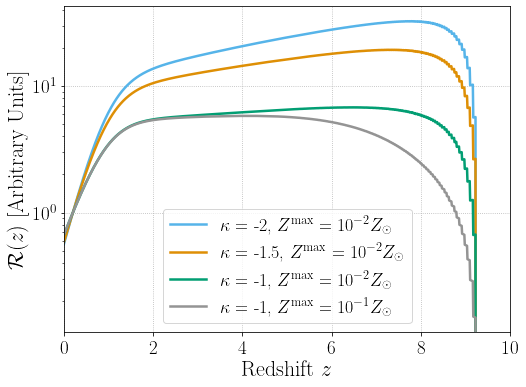

In [12]:
plt.plot(zs, R_norm_VA(zs,1e-2,-2)[0]/R_norm_VA(zs,1e-2,-2)[1], label="$\kappa$ = -2, $Z^{\\rm max}=10^{-2}Z_\odot$", c = my_palette[-1],lw=2.5)
plt.plot(zs, R_norm_VA(zs,1e-2,-1.5)[0]/R_norm_VA(zs,1e-2,-1.5)[1], label="$\kappa$ = -1.5, $Z^{\\rm max}=10^{-2}Z_\odot$", c = my_palette[1],lw=2.5)
plt.plot(zs, R_norm_VA(zs,1e-2,-1)[0]/R_norm_VA(zs,1e-2,-1)[1], label="$\kappa$ = -1, $Z^{\\rm max}=10^{-2}Z_\odot$", c = my_palette[2],lw=2.5)
plt.plot(zs, R_norm_VA(zs,1e-1,-1)[0]/R_norm_VA(zs,1e-1,-1)[1], label="$\kappa$ = -1, $Z^{\\rm max}=10^{-1}Z_\odot$", c = my_palette[-3],lw=2.5)
plt.yscale('log')
plt.xlabel('Redshift $z$', fontsize=22)
plt.legend(fontsize=18)
plt.xlim(0,10)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.ylabel('$\mathcal{R}(z)$ [Arbitrary Units]', fontsize=22)
plt.grid(visible=True, ls='dotted')
plt.show()

## Figure 7 - Right

In [6]:
sys.path.append("../code/")

In [7]:
from gwBackground import *

In [8]:
all_zs = np.linspace(0,10,200) #Should be 1000, just took it 10 for testing
omg = OmegaGW_BBH(2.1,100.,all_zs)

In [9]:
freqs = np.arange(10,1000,1)

In [10]:
mMin = 10
mMax = 80
alpha=-2
mu_m1 = 20
sig_m1 = 3
f_peak=.01
bq = 2
R20=1
dmMax = 3
dmMin=1
omg.setProbs_plPeak(mMin,mMax,alpha,mu_m1,sig_m1,f_peak,bq,R20, dmMax,dmMin)

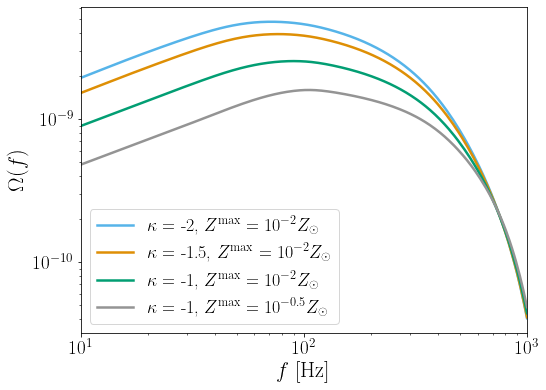

In [11]:
merger_rate_tmp, rate_02_tmp = R_norm_VA(zs, 1e-2,-2)
rate_tmp = jnp.interp(all_zs, zs, merger_rate_tmp)
Omega_f = omg.eval(rate_tmp, rate_02_tmp, freqs)
plt.loglog(freqs, Omega_f, label="$\kappa$ = -2, $Z^{\\rm max}=10^{-2}Z_\odot$", c = my_palette[-1],lw=2.5)
merger_rate_tmp, rate_02_tmp = R_norm_VA(zs, 1e-2,-1.5)
rate_tmp = jnp.interp(all_zs, zs, merger_rate_tmp)
Omega_f = omg.eval(rate_tmp, rate_02_tmp, freqs)
plt.loglog(freqs, Omega_f, label="$\kappa$ = -1.5, $Z^{\\rm max}=10^{-2}Z_\odot$", c = my_palette[1],lw=2.5)
merger_rate_tmp, rate_02_tmp = R_norm_VA(zs, 1e-2,-1)
rate_tmp = jnp.interp(all_zs, zs, merger_rate_tmp)
Omega_f = omg.eval(rate_tmp, rate_02_tmp, freqs)
plt.loglog(freqs, Omega_f, label="$\kappa$ = -1, $Z^{\\rm max}=10^{-2}Z_\odot$", c = my_palette[2],lw=2.5)
merger_rate_tmp, rate_02_tmp = R_norm_VA(zs, 1e-1,-0.5)
rate_tmp = jnp.interp(all_zs, zs, merger_rate_tmp)
Omega_f = omg.eval(rate_tmp, rate_02_tmp, freqs)
plt.loglog(freqs, Omega_f, label="$\kappa$ = -1, $Z^{\\rm max}=10^{-0.5}Z_\odot$", c = my_palette[-3],lw=2.5)
plt.xlabel('$f$ [Hz]', fontsize=22)
plt.legend(fontsize=18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlim(10,1000)
plt.ylabel('$\Omega(f)$', fontsize=22)